In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

In [2]:
def torrToBar(pressure_Torr):
    """
    Convert the gas pressure units from Torr to Bar.
    
    Inputs:
    pressure_Torr: gas pressure [Torr]
    
    Outputs:
    pressure_Bar: gas pressure [Bar]
    """
    
    pressure_Pa = pressure_Torr * (101325/760)
    pressure_Bar = pressure_Pa * 1e-5
    
    return pressure_Bar

In [3]:
def calculateOutputFrequencyLimit(simulation_window, simulation_points):
    """
    Calculate the upper limit on the output frequency of the output pulse.
    
    Inputs:
    simulation_window: total time window of the simulation in picoseconds [ps]
    simulation_points: number of steps the simulation takes as the pulse propagates through the fiber
    
    Outputs:
    output_frequency_limit: upper limit on the frequency of the output pulse in THz [THz]
    """
    
    time_step = simulation_window / simulation_points
    sampling_rate = 1 / time_step
    output_frequency_limit = 0.5 * sampling_rate
    
    return output_frequency_limit

In [4]:
def nonlinearIndexN2(pressure, n2_at_one_bar):
    """
    Calculate the nonlinear refractive index n2.
    
    Inputs:
    pressure: pressure of the gas, constant or a function of the length along the fiber [Bar] or [Bar/m]
    n2_at_one_bar: nonlinear refractive index of the gas quoted at pressure = 1Bar [m^2/(W bar)]
    
    Output:
    n2: nonlinear refractive index n2 at specified pressure [m^2/W]
    """
    
    n2 = pressure * n2_at_one_bar
    
    return n2

In [5]:
def nonlinearParameterGamma(n2, pulseWL, fiber_rad):
    """
    Calculate the nonlinear parameter Gamma.
    Based on equation from Agrawal's "Nonlinear Fiber Optics": Gamma = (n2*omega0)/(c*A_eff)
    
    c: speed of light [m/s]
    omega0 = (2*pi*c)/pulseWL: angular frequency [rad/s]
    A_eff: effective core area of the fiber [m^2]
    
    Inputs:
    n2: nonlinear refractive index at specified pressure [m^2/W]
    pulseWL: pulse central wavelength [nm]
    fiber_rad: radius of fiber [m]
    
    Output:
    Gamma: nonlinear parameter [1/(W km)]
    """
    
    Gamma = ((2*np.pi)/(pulseWL*1e-9)) * (n2/(np.pi*fiber_rad**2)) * (1/1e-3)
    
    return Gamma

In [6]:
# pulse parameters
FWHM = 0.16         # pulse duration (ps)
pulseWL = 1035      # fundamental pulse central wavelength (nm)
EPP = 2e-6          # Energy per pulse (J)
GDD = 0.0           # Group delay dispersion (ps^2)
TOD = 0.0           # Third order dispersion (ps^3)


# fibre parameters
Length = 100        # length in mm
Alpha = 0.0         # attentuation coefficient (dB/cm)
fiber_rad = 15e-6   # radius (m)
fibWL = pulseWL     # Center WL of fiber (nm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# Xenon gas at 800nm, dispersive coefficients (betas), pressure-dependent nonlinear refractive index (n2)
beta2 = 0.9113                    # (fs^2/cm)
beta3 = 0.7836                    # (fs^3/cm)
n2_Xe_at_one_bar = 1.115e-22      # (m^2/(W bar)), (Arnaud Couairon et al, 2008)

pressure = 2.31                                    # (bar)
n2 = nonlinearIndexN2(pressure, n2_Xe_at_one_bar)  # (m^2/W)

beta2 *= (1e-3)**2/1e-5           # (ps^2/km)
beta3 *= (1e-3)**3/1e-5           # (ps^3/km)
beta4 = 0                         # (ps^4/km) (value not found)

Gamma = nonlinearParameterGamma(n2, pulseWL, fiber_rad)  # (1/(W km))


# simulation parameters
Window = 2.5       # simulation window (ps)
Steps = 100         # simulation steps
Points = 2**15      # simulation points
Raman = True        # Enable Raman effect?
Steep = True        # Enable self steepening?

print(f"The proposed upper limit on the frequency of the output pulse is {calculateOutputFrequencyLimit(Window, Points)} THz.")


The proposed upper limit on the frequency of the output pulse is 6553.6 THz.


In [7]:
# customise Gamma from pressure gradient

xdata = np.array([0,20,40,60,80,90,100])*1e-3
ydata = torrToBar(np.array([1000.0,850.0,750.0,650.0,450.0,300.0,0.0]))

coeff = np.polyfit(xdata, ydata, 3)
customised_pressure = np.poly1d(coeff)

n2 = nonlinearIndexN2(customised_pressure, n2_Xe_at_one_bar)
Gamma = nonlinearParameterGamma(n2, pulseWL, fiber_rad)


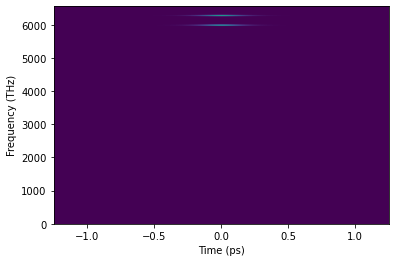

In [8]:
# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    4, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_FD.set_epp(EPP)

# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(
    3, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL/2)
pulse_SH.set_epp(EPP)

# combine the pulses
pulse = pynlo.light.DerivedPulses.SechPulse(
    7, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse.set_AT(pulse_FD.AT + pulse_SH.AT)

# create the combined pulse's spectrogram
plt.figure()
DELAYS, FREQS, extent, spectrogram = pulse.spectrogram()
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel('Time (ps)')
plt.ylabel('Frequency (THz)')
plt.show()


In [9]:
print(f"The fundamental pulse has center wavelength {pulse_FD.center_wavelength_nm} nm and center frequency {pulse_FD.center_frequency_THz} THz.")
print(f"The second harmonic pulse has center wavelength {pulse_SH.center_wavelength_nm} nm and center frequency {pulse_SH.center_frequency_THz} THz.")
print(f"The combined pulse has center wavelength {pulse.center_wavelength_nm} nm and center frequency {pulse.center_frequency_THz} THz.")


The fundamental pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.
The second harmonic pulse has center wavelength 517.5 nm and center frequency 579.3090975845411 THz.
The combined pulse has center wavelength 1035.0 nm and center frequency 289.65454879227053 THz.


In [10]:
# create the fiber
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma(0) * 1e-3, gvd_units='ps^n/km', gain=-alpha)
fiber1.set_gamma_function(Gamma * 1e-3)

# fiberloader = pynlo.media.fibers.JSONFiberLoader.JSONFiberLoader()
# fiberloader.print_fiber_list()


In [11]:
# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps, reload_fiber_each_step=True)


Pulse energy before Simple Fiber : 3999.999999999993 nJ
pulse energy in  15771690.97939292
copied as   15771690.97939292
Step: 0 Distance remaining: 0.1
Pulse energy after: 3996.661809460322 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 3996.705484671827 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 3996.7600273399867 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 3996.8226711936345 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 3996.8979103171614 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 3996.9821858122286 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 3997.0616793548074 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 3997.126482555843 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 3997.1768009997245 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 3997.2151616918172 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 3997.235883010961 nJ
Step: 

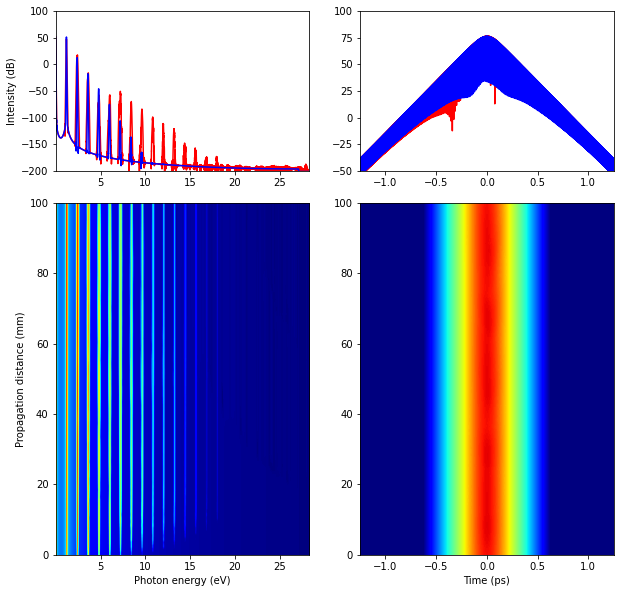

In [12]:
F = (pulse.W_mks / (2*np.pi)) * 1e-12 # convert to THz
EV = 6.626e-34 * (pulse.W_mks / (2*np.pi)) / 1.602e-19

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


ax0.plot(EV[EV > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps, zT[-1], color='r')

ax0.plot(EV[EV > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(EV[EV > 0]), np.max(EV[EV > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                 vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')


ax2.set_xlabel('Photon energy (eV)')
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Intensity (dB)')
ax2.set_ylabel('Propagation distance (mm)')

# ax2.set_xlim(0,3)
ax0.set_ylim(-200,100)
ax1.set_ylim(-50,100)

plt.show()